#### TRANSECT BENCHMARK WITH THREE GRIDDING APPROACHES (Rectilinear, Vertically Staggered, Vertically Offset)

In [1]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import math
np.set_printoptions(precision=6)

sim_name = 'TRANSECT'
modelnames = ['RL', 'VO', 'VS']
#workspace = '../Model/'
#exe_name = '../exe/mf6.exe'
workspace = './transect_benchmark/'
exe_name = './bin/mf6'

In [2]:
def write_input_files(gwf,modelname):
    headfile = '{}.hds'.format(modelname)
    head_filerecord = [headfile]
    budgetfile = '{}.cbb'.format(modelname)
    budget_filerecord = [budgetfile]
    saverecord, printrecord = [('HEAD', 'ALL'), ('BUDGET', 'ALL')], [('HEAD', 'ALL')]
    oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(gwf, pname='oc', saverecord=saverecord, head_filerecord=head_filerecord,
                                                budget_filerecord=budget_filerecord, printrecord=printrecord)

def get_data(modelname, workspace):
    fpth = os.path.join(workspace, modelname +'.hds')
    hds = flopy.utils.binaryfile.HeadFile(fpth)  
    times = hds.get_times()
    head = hds.get_data() #(totim=times[-1])
    
    fpth = os.path.join(workspace, modelname +'.cbb')
    cbc = flopy.utils.binaryfile.CellBudgetFile(fpth)
    flowja = cbc.get_data(text='FLOW-JA-FACE')[0][0][0]
    spd = cbc.get_data(text='DATA-SPDIS')[0]
    chdflow = cbc.get_data(text='CHD')[-1]
    return(head, spd, chdflow, flowja)

def find_kji(cell,nlay,nrow,ncol): #cellid is zerobased
    import math
    cellid = cell - 1
    k = math.floor(cellid/(ncol*nrow)) # Zero based
    j = math.floor((cellid - k*ncol*nrow)/ncol) # Zero based
    i = cellid - k*ncol*nrow - j*ncol
    return(k,j,i) # ZERO BASED!

def find_cellid(k,j,i,nlay,nrow,ncol): # returns zero based cell id
    return(i + j*ncol + k*ncol*nrow)

def get_q_dis(spd,nlay,nrow,ncol):
    q, qdir =  np.zeros((nlay,nrow,ncol)), np.zeros((nlay,nrow,ncol))
    qx, qy, qz = np.zeros((nlay,nrow,ncol)), np.zeros((nlay,nrow,ncol)), np.zeros((nlay,nrow,ncol))
    for rec in spd:   
        cell = rec[0]
        k,j,i = find_kji(cell,nlay,nrow,ncol)
        q[k,j,i] = np.sqrt(rec[3]**2 + rec[4]**2 + rec[5]**2)
        qx[k,j,i] = rec[3]
        qy[k,j,i] = rec[4]
        qz[k,j,i] = rec[5]
        qdir[k,j,i] = math.degrees(math.atan(rec[5]/rec[3]))
    return(q,qx,qy,qz,qdir)

def upper_lower(slope,x, channel_vertical):
    upper = slope * x + 100+channel_vertical # upper channel boundary
    lower = slope * x + 100 # lower channel boundary
    return(upper,lower)

def head_analytical(h0, theta, hg, x, z):
    head = h0 - hg * math.cos(math.radians(theta))*x - hg * math.sin(math.radians(theta))*z
    return(head)

def ch_flow(chdflow):
    flow_in, flow_out = 0., 0.
    for j in range(len(chdflow)):        
        if chdflow[j][2]>0: flow_out += chdflow[j][2]
        if chdflow[j][2]<0: flow_in  += chdflow[j][2]      
    return((flow_in, flow_out))

def get_q_disu(spd, flowja, gwf, staggered):

    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spd, gwf)
    # if cross-connections, recalculate qx taking into account overlap areas
    if staggered:
        gp = d2d.get_gridprops_disu6()
        iac = gp["iac"]
        ja = gp["ja"]
        ihc = gp["ihc"]
        topbycell = gp["top"]
        botbycell = gp["bot"]
        hwva = gp["hwva"]
        iconn = -1
        icell = -1
        for il in iac:
            icell += 1
            qxnumer = 0.
            qxdenom = 0.
            for ilnbr in range(il):
                iconn += 1
                if ihc[iconn] == 2:
                    inbr = ja[iconn]
                    if (inbr == icell):
                        continue
                    dz = min(topbycell[icell], topbycell[inbr]) - max(botbycell[icell], botbycell[inbr])
                    qxincr = flowja[iconn] / (hwva[iconn] * dz)
                    # equal weight given to each face, but could weight by distance instead
                    if (inbr < icell):
                        qxnumer += qxincr
                    else:
                        qxnumer -= qxincr
                    qxdenom += 1.
            qx[icell] = qxnumer / qxdenom

    print(len(spd))
    qmag, qdir = [], []
    for i in range(len(spd)):
        qmag.append(np.sqrt(qx[i]**2 + qy[i]**2 + qz[i]**2))
        qdir.append(math.degrees(math.atan(qz[i]/qx[i])))      
    return(qmag,qx,qy,qz,qdir)

#### Variables

In [3]:
Lx, Ly, Lz = 1000., 1., 1000.
nlay1, nrow1, ncol1 = 28, 1, 28 #COARSE: 28,1,28 # FINE: 128,1,128 (These correspond to flexible "COARSE" and "FINE" in plan) 
top = np.ones((nrow1,ncol1)) * Lz

k1, k2, k3 = 1., 1., 1. # K in channel
kdomain = 0.000001        # K in domain
angle1, angle2, angle3 = 0., 0., 0. # Used for K tensors - Change Angle 2 for anisotropic
xt3d = True

theta = 30. # Used for channel slope
slope = math.tan(math.radians(theta))
channel_vertical = 200 /math.cos(math.radians(30))
channel_width = channel_vertical*math.cos(math.radians(30)) # width perpendicular to channel edges

hg = 1. # Enforced hydraulic gradient
h0 = 10. # theoretical head at (0,0) to form equation of plane 
strt = -500. # starting head

nper, perlen, nts  = 1, 1., 1   # Steady-state
perioddata = [(perlen, nts, 1.0)]

all_gwf, all_ncells = [], []

# SIMULATION
sim = flopy.mf6.MFSimulation(sim_name=sim_name, version='mf6',exe_name=exe_name,sim_ws=workspace)
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim, time_units='DAYS', nper=nper,perioddata=perioddata)
#ims = flopy.mf6.ModflowIms(sim, print_option='ALL', complexity='complex',outer_hclose=1.e-3, inner_hclose=1.e-3)
## SOLVER FOR ANISOTROPIC CHANNEL
ims = flopy.mf6.ModflowIms(sim, print_option='ALL', complexity='moderate',under_relaxation='simple',
                           under_relaxation_gamma = 0.25, outer_maximum = 500, outer_hclose=1.e-2, inner_hclose=1.e-2)

#### Method 1 - Rectilinear Discretisation (RL)

In [4]:
# RL INPUTS
all_ncells.append(nlay1*nrow1*ncol1)
delr1, delc1, delz1 = Lx/ncol1, Ly/nrow1, Lz/nlay1

botm1 = np.ones((nlay1,nrow1,ncol1))
for lay in range(nlay1):
    for col in range(ncol1):
        botm1[lay,0,col] = Lz - delz1 * (lay + 1)
    
mask1 = np.ones((nlay1,nrow1,ncol1))
for lay in range(nlay1):
    for col in range(ncol1):
        x = delr1/2 + delr1 * col
        z = Lz - delz1/2 - delz1 * lay
        upper, lower = upper_lower(slope,x, channel_vertical)
        if z < lower or z > upper:
            mask1[lay,0,col] = 0   
            
k11, k22, k33 = kdomain * np.ones((nlay1,nrow1,ncol1)), kdomain * np.ones((nlay1,nrow1,ncol1)), kdomain * np.ones((nlay1,nrow1,ncol1))
CH_mask1 = np.zeros((nlay1,nrow1,ncol1))
chd_rec = []

for k in range(nlay1):
    for j in range(nrow1):
        for i in range(ncol1):
            x = delr1/2 + i*delr1
            z = Lz - (delz1/2 + k*delz1)
            if mask1[k,j,i] != 0:              
                k11[k,j,i] = k1 # K in channel
                k22[k,j,i] = k2 # K in channel
                k33[k,j,i] = k3 # K in channel
            if i == 0 or i == ncol1-1 or k == 0 or k == nlay1-1: # Points within channel AND along boundary
                CH_mask1[k][j][i] = 1
                ch = head_analytical(h0, theta, hg, x, z) # CH in channel
                chd_rec.append(((k, j, i), ch)) # CH in channel
                
# RL MODEL
modelname=modelnames[0]
gwf = flopy.mf6.ModflowGwf(sim, modelname=modelname, save_flows=True)
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf, nlay=nlay1, nrow=nrow1, ncol=ncol1, 
                                                   delr=delr1,delc=delc1,top=top, botm=botm1) 
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)
chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, maxbound=len(chd_rec), stress_period_data=chd_rec)
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, xt3doptions=xt3d,k=k11, k22=k22, k33=k33, 
                                               angle1 = angle1, angle2 = angle2, angle3 = angle3,
                                               save_flows=True, save_specific_discharge=True)
write_input_files(gwf,modelname)
all_gwf.append(gwf)

In [5]:
## Method 1 Analytical
h_1_analytical = np.zeros((nlay1,nrow1,ncol1))
q_1_analytical = np.zeros((nlay1,nrow1,ncol1))

for k in range(nlay1):
    for j in range(nrow1):
        for i in range(ncol1):
            x = delr1/2 + i*delr1
            z = Lz - (delz1/2 + k*delz1)
            h_1_analytical[k,j,i] = head_analytical(h0, theta, hg, x, z)
            q_1_analytical[k,j,i] = hg * k1

#### Method 2 - Vertically Offset (VO)

In [6]:
# VO INPUTS
nrow2, ncol2 = 1, ncol1 # Same number of columns as RL 
delr2, delc2 = Lx/ncol2, Ly/nrow2

nlay_channel = int(channel_vertical/delr2) # nlay in channel, so that cells in channel are square as are RL
del_channel = channel_vertical / nlay_channel # delz of cells within channel

channel_upper = slope * Lx + 100 + channel_vertical
nlay_upper = np.copy(nlay_channel) # arbitrary, but just make the same number of layers as in channel 
nlay_lower = np.copy(nlay_channel) # arbitrary, but just make the same number of layers as in channel
nlay2 = nlay_channel + nlay_upper + nlay_lower
all_ncells.append(nlay2 * nrow2 * ncol2)

botm2, mask2 = np.ones((nlay2,nrow2,ncol2)), np.ones((nlay2,nrow2,ncol2))
for col in range(ncol2):   
    x = delr2/2 + delr2 * col
    upper, lower = upper_lower(slope,x, channel_vertical)
    upper_thickness, lower_thickness = Lz - upper, lower # aquifer thickness above and below channel
    del_upper = upper_thickness / nlay_upper  # layer thickness
    del_lower = lower_thickness / nlay_lower  # layer thickness

    for n, i in enumerate(range(0,nlay_upper)): # layer bottoms above channel
        botm2[i,0,col] = Lz - (n+1) * del_upper
    for n, i in enumerate(range(nlay_upper, nlay_upper + nlay_channel)): # layer bottoms in channel
        botm2[i,0,col] = upper - (n+1) * del_channel
    for n, i in enumerate(range(nlay_upper + nlay_channel,nlay2)): # layer bottoms below channel
        botm2[i,0,col] = lower - (n+1) * del_lower
    botm2[nlay2-1,0,col] = 0.
    #print(nlay_upper * del_upper + nlay_channel*del_channel + nlay_lower * del_lower)

    # MASK FOR CHANNEL
    for lay in range(nlay_upper):
        mask2[lay,0,col] = 0 # top layer
    for lay in range(nlay2 - nlay_lower, nlay2):
        mask2[lay,0,col] = 0 # 3rd bottom layer
        
# CH and NPF
ones = np.ones((nlay2,nrow2,ncol2))
k11, k22, k33 = kdomain * ones, kdomain * ones, kdomain * ones  
chd_rec = []
CH_mask2 = np.zeros((nlay2,nrow2,ncol2))
for k in range(nlay2):
    for j in range(nrow2):
        for i in range(ncol2):
            x = delr2/2 + i*delr2
            if k == 0:
                z = botm2[k,j,i] + (top[j,i] - botm2[k,j,i])/2
            else:
                z = botm2[k,j,i] + (botm2[k-1,j,i] - botm2[k,j,i])/2 
            if mask2[k,j,i] == 1:                
                k11[k,j,i] = k1 # K in channel
                k22[k,j,i] = k2 # K in channel
                k33[k,j,i] = k3 # K in channel
            if i == 0 or i == ncol2-1 or k == 0 or k == nlay2-1: 
                CH_mask2[k][j][i] = 1
                ch = head_analytical(h0, theta, hg, x, z) 
                chd_rec.append(((k, j, i), ch)) 

#### Method 2 - Vertically Offset

In [7]:
# VO MODEL 
modelname=modelnames[1]
gwf = flopy.mf6.ModflowGwf(sim, modelname=modelname, save_flows=True)
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf, nlay=nlay2, nrow=nrow2, ncol=ncol2, 
                                                   delr=delr2,delc=delc2,top=top, botm=botm2) 
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)       
chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, maxbound=len(chd_rec), 
                                               stress_period_data=chd_rec, print_flows=True, save_flows=True)
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, xt3doptions=xt3d,k=k11, k22=k22, k33=k33, 
                                               angle1 = angle1, angle2 = angle2, angle3 = angle3,
                                               save_flows=True, save_specific_discharge=True)
write_input_files(gwf,modelname)
all_gwf.append(gwf)

#### Method 3 - Vertically Staggered

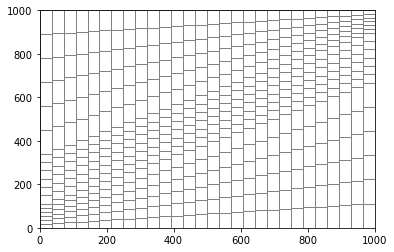

In [8]:
### CONVERT VERTICALLY OFFSET TO DISU
import flopy.plot.styles as styles ###
from dis2disu import Dis2Disu ### 
staggered = True
delr = delr2 * np.ones(ncol2, dtype=float)
delc = delc2 * np.ones(nrow2, dtype=float)
mgs = flopy.discretization.StructuredGrid(delr=delr, delc=delc, top=top, botm=botm2)
if ncol1 <= 40:
    xs = flopy.plot.PlotCrossSection(modelgrid=mgs, line={"row":0})
    xs.plot_grid()
d2d = Dis2Disu(delr, delc, top, botm2, staggered=True)

#help(d2d)
#print(d2d.get_gridprops_disu6())

In [9]:
chd_spd = []
for rec in range(len(chd_rec)):
    k, j, i = chd_rec[rec][0]
    cellid = find_cellid(k,j,i,nlay2, nrow2, ncol2)
    chd_spd.append([cellid, chd_rec[rec][1]])
    
k11.shape
k11_usg, k33_usg = [], []
for k in range(nlay2):
    for j in range(nrow2):
        for i in range(ncol2):
            cellid = find_cellid(k,j,i,nlay2, nrow2, ncol2)
            k11_usg.append(k11[k,j,i])
            k33_usg.append(k33[k,j,i])

modelname=modelnames[2] # VS MODEL 
gwf = flopy.mf6.ModflowGwf(sim, modelname=modelname, save_flows=True)
disu = flopy.mf6.ModflowGwfdisu(gwf, **d2d.get_gridprops_disu6()) #### DISU
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)       
chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, stress_period_data=chd_spd)

npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, xt3doptions=xt3d,k=k11_usg, k22=k11_usg, k33=k33_usg, 
                                               angle1 = angle1, angle2 = angle2, angle3 = angle3, save_flows=True, save_specific_discharge=True)
write_input_files(gwf,modelname)
all_gwf.append(gwf)


In [10]:
### ANALYTICAL
xc = gwf.modelgrid.xcellcenters[0:ncol2]
z = gwf.modelgrid.zcellcenters[0]
zc = np.zeros((nlay2, ncol2))
ncells2 = nlay2 * nrow2 * ncol2
for cell in range(ncells2):
    lay, row, col = find_kji(cell,nlay2,nrow2,ncol2)
    zc[lay][col] = z[cell]     

h_2_analytical = np.zeros((nlay2,nrow2,ncol2))
q_2_analytical = np.zeros((nlay2,nrow2,ncol2))

for lay in range(nlay2):
    for col in range(ncol2):
        x = xc[col]
        z = zc[lay][col]
        #point = Point(x,y)
        h_2_analytical[lay,0,col] = head_analytical(h0, theta, hg, x, z)
        q_2_analytical[lay,0,col] = hg * k1

#### Run Simulation

In [11]:
sim.write_simulation()
success, buff = sim.run_simulation()
print('\nSuccess is: ', success)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model RL...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package chd_0...
    writing package npf...
    writing package oc...
  writing model VO...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package chd_0...
    writing package npf...
    writing package oc...
  writing model VS...
    writing model name file...
    writing package disu...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 88 based on size of stress_period_data
    writing package npf...
    writing package oc...
FloPy is using the following executable to run the model: ./bin/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        

#### Model setups

In [12]:
'''# CH boundaries
plt.figure(figsize=(10,5))                   
plt.subplot(121, aspect = 'equal') # RL
xsect = flopy.plot.PlotCrossSection(model=all_gwf[0], line={'Row': 0})
quadmesh = xsect.plot_array(CH_mask1, cmap='Blues')
linecollection = xsect.plot_grid(color = 'black', linewidths=0.8)

plt.subplot(122, aspect = 'equal') # VO
xs = flopy.plot.PlotCrossSection(model=all_gwf[1], line={"line": [(0.0, 0.5), (Lx, 0.5)]})
cb = xs.plot_array(CH_mask2, cmap='Blues')
xs.plot_grid(color = 'black', linewidths=0.8)'''

'# CH boundaries\nplt.figure(figsize=(10,5))                   \nplt.subplot(121, aspect = \'equal\') # RL\nxsect = flopy.plot.PlotCrossSection(model=all_gwf[0], line={\'Row\': 0})\nquadmesh = xsect.plot_array(CH_mask1, cmap=\'Blues\')\nlinecollection = xsect.plot_grid(color = \'black\', linewidths=0.8)\n\nplt.subplot(122, aspect = \'equal\') # VO\nxs = flopy.plot.PlotCrossSection(model=all_gwf[1], line={"line": [(0.0, 0.5), (Lx, 0.5)]})\ncb = xs.plot_array(CH_mask2, cmap=\'Blues\')\nxs.plot_grid(color = \'black\', linewidths=0.8)'

#### Get outputs

In [13]:
# Get data and array of fluxes
all_h, all_spd = [], []
all_q, all_qxqyqz, all_qdir, all_flow = [], [], [], []
all_nlay = [nlay1,nlay2,nlay2]
all_ncol = [ncol1,ncol2,ncol2]

# Method 1 - RECTILINEAR
head, spd, chdflow, flowja = get_data(modelnames[0], workspace)
all_h.append(head)
all_spd.append(spd)
qmag,qx,qy,qz, qdir = get_q_dis(spd,nlay1,nrow1,ncol1)
all_q.append(qmag)
all_qxqyqz.append((qx,qy,qz))
all_qdir.append(qdir)
all_flow.append(ch_flow(chdflow))

# Method 2 - VERTICALLY OFFSET
head, spd, chdflow, flowja = get_data(modelnames[1], workspace)
all_h.append(head)
all_spd.append(spd)
qmag,qx,qy,qz, qdir = get_q_dis(spd,nlay2,nrow2,ncol2)
all_q.append(qmag)
all_qxqyqz.append((qx,qy,qz))
all_qdir.append(qdir)
all_flow.append(ch_flow(chdflow))

# Method 3 - VERTICALLY STAGGERED
head, spd, chdflow, flowja = get_data(modelnames[2], workspace)
all_h.append(head)
all_spd.append(spd)
qmag,qx,qy,qz, qdir = get_q_disu(spd, flowja, all_gwf[2], staggered)
all_q.append(qmag)
all_qxqyqz.append((qx,qy,qz))
all_qdir.append(qdir)
all_flow.append(ch_flow(chdflow))


504


### Find q mag and theta in centre

In [14]:
q_centre, theta_centre = [], []

# Method 1
qx1 = all_qxqyqz[0][0][int(nlay1/2),0,int(ncol1/2)]
qy1 = all_qxqyqz[0][1][int(nlay1/2),0,int(ncol1/2)]
qz1 = all_qxqyqz[0][2][int(nlay1/2),0,int(ncol1/2)]
q_centre.append(all_q[0][int(nlay1/2),0,int(ncol1/2)])
theta_centre.append(math.degrees(math.atan(qz1/qx1)))

# Method 2
qx2 = all_qxqyqz[1][0][int(nlay2/2),0,int(ncol2/2)]
qy2 = all_qxqyqz[1][1][int(nlay2/2),0,int(ncol2/2)]
qz2 = all_qxqyqz[1][2][int(nlay2/2),0,int(ncol2/2)]
q_centre.append(all_q[1][int(nlay2/2),0,int(ncol2/2)])
theta_centre.append(math.degrees(math.atan(qz2/qx2)))

# Method 3
colmid = int(ncol2 / 2)
laymid = int(nlay2 / 2)
centre_cell = find_cellid(laymid,0,colmid,nlay2,nrow2,ncol2)
q_centre.append(qmag[centre_cell])
theta_centre.append(qdir[centre_cell])

print('RECTILINEAR FLUX',q_centre[0])
print('RECTILINEAR ANGLE',theta_centre[0])

print('\nVERTICALLY OFFSET FLUX', q_centre[1])
print('VERTICALLY OFFSET ANGLE', theta_centre[1])

print('\nVERTICALLY STAGGERED FLUX', q_centre[2])
print('VERTICALLY STAGGERED ANGLE', theta_centre[2])

RECTILINEAR FLUX 1.0260419507626544
RECTILINEAR ANGLE 29.401845754318582

VERTICALLY OFFSET FLUX 1.1122310814256653
VERTICALLY OFFSET ANGLE 0.09875639323455092

VERTICALLY STAGGERED FLUX 1.0020306449276792
VERTICALLY STAGGERED ANGLE 30.04893282336259


#### WHOLE MODEL (USE WITH COARSE RESOLUTION)

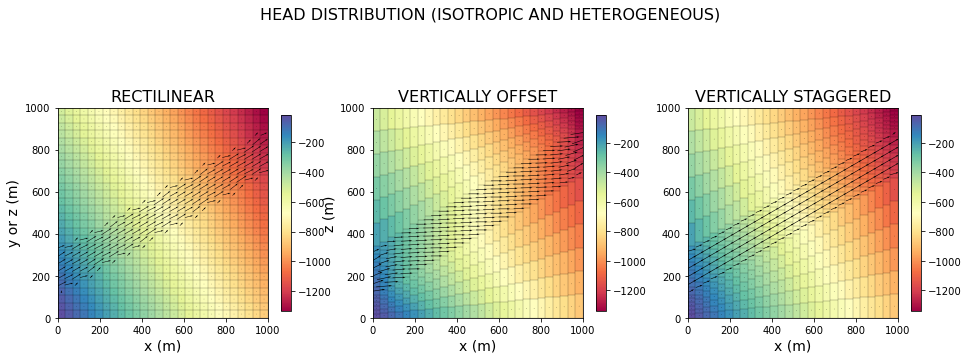

In [15]:
if ncol1 <= 40: # Plots only for coarse resolution
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    titles = ['RECTILINEAR', 'VERTICALLY OFFSET', 'VERTICALLY STAGGERED']

    # Plot head
    fig, axes = plt.subplots(1,3, figsize=(16, 6),sharex=True, sharey=True)
    if kdomain == 1:
        if k1 == k3: fig.suptitle("HEAD DISTRIBUTION (ISOTROPIC AND HOMOGENEOUS)", size = 16)
        if k1 != k3: fig.suptitle("HEAD DISTRIBUTION (ANISOTROPIC AND HOMOGENEOUS)", size = 16)
    if kdomain < 1:
        if k1 == k3: fig.suptitle("HEAD DISTRIBUTION (ISOTROPIC AND HETEROGENEOUS)", size = 16)
        if k1 != k3: fig.suptitle("HEAD DISTRIBUTION (ANISOTROPIC AND HETEROGENEOUS)", size = 16)

    for i, ax in enumerate(axes.flat):

        gwf = all_gwf[i] # Get grid details for model
        head = all_h[i]
        nlay, nrow, ncol = all_nlay[i], 1, all_ncol[i]
        ax = plt.subplot(1,3,i+1,aspect='equal')
        ax.set_title(titles[i], size = 16)  

        xs = flopy.plot.PlotCrossSection(model=all_gwf[i], line={"line": [(0.0, 0.5), (Lx, 0.5)]})
        cb = xs.plot_array(a = head, masked_values=[1e30], cmap = 'Spectral',alpha=1.0)
        xs.plot_grid(lw = 0.1, color = 'black')


        vx, vy, vz = all_qxqyqz[i]
        xs.plot_vector(vx, vy, vz, scale = 20, color='black')#headwidth=2, headlength=0.1, headaxislength=2.)

        ax.set_xlabel('x (m)', size = 14)
        if i == 0: ax.set_ylabel('y or z (m)', size = 14)
        if i == 1: ax.set_ylabel('z (m)', size = 14)
        plt.colorbar(cb, shrink = 0.6)

504


(-1400.0, 0.0)

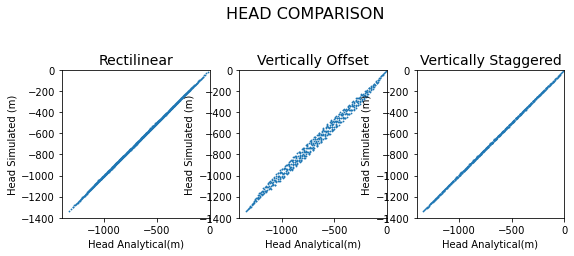

In [16]:
fig, axes = plt.subplots(1,3, figsize=(9, 4))
fig.suptitle("HEAD COMPARISON", size = 16)

# RECTILINEAR
gwf = all_gwf[0] 
head = all_h[0]
xcellcentres = gwf.modelgrid.xcellcenters
zcellcentres = gwf.modelgrid.zcellcenters
h1, h2 = [], []
for k in range(nlay1):
    for i in range(ncol1):
        h1.append(head_analytical(h0, theta, hg, xcellcentres[0,i], zcellcentres[k,0,i])) # anlaytical
        h2.append(head[k,0,i]) # simulated
ax1 = plt.subplot(131,aspect='equal')
ax1.plot(h1,h2,'o', ms = 0.8)
ax1.set_title('Rectilinear', size = 14)  
ax1.set_xlabel('Head Analytical(m)')
ax1.set_ylabel('Head Simulated (m)')
ax1.set_xlim([-1400,0]) 
ax1.set_ylim([-1400,0])

# VERTICALLY OFFSET
gwf = all_gwf[1] 
head = all_h[1]
xcellcentres = gwf.modelgrid.xcellcenters
zcellcentres = gwf.modelgrid.zcellcenters
h1, h2 = [], []
for k in range(nlay2):
    for i in range(ncol2):
        h1.append(head_analytical(h0, theta, hg, xcellcentres[0,i], zcellcentres[k,0,i])) # anlaytical
        h2.append(head[k,0,i]) # simulated
ax2 = plt.subplot(132,aspect='equal')
ax2.plot(h1,h2,'o', ms = 0.8)
ax2.set_title('Vertically Offset', size = 14)  
ax2.set_xlabel('Head Analytical(m)')
ax2.set_ylabel('Head Simulated (m)')
ax2.set_xlim([-1400,0]) 
ax2.set_ylim([-1400,0])

# VERTICALLY STAGGERED
gwf = all_gwf[2] 
head = all_h[2]
print(len(head[0][0]))
xcellcentres = gwf.modelgrid.xcellcenters
zcellcentres = gwf.modelgrid.zcellcenters[0]

h1, h2 = [], []
for icell in range(len(spd)):
    h1.append(head_analytical(h0, theta, hg, xcellcentres[icell], zcellcentres[icell])) # anlaytical
    h2.append(head[0][0][icell]) # simulated
ax3 = plt.subplot(133,aspect='equal')
ax3.plot(h1,h2,'o', ms = 0.8)
ax3.set_title('Vertically Staggered', size = 14)  
ax3.set_xlabel('Head Analytical(m)')
ax3.set_ylabel('Head Simulated (m)')
ax3.set_xlim([-1400,0]) 
ax3.set_ylim([-1400,0])           

#### ZOOMED IN PLOT OF CHANNEL (USE WITH FINE RESOLUTION)

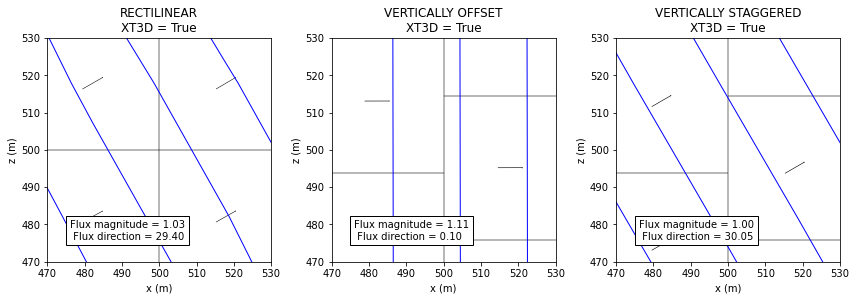

In [17]:
from scipy.interpolate import griddata
xG = np.linspace(delr1/2, Lx - delr1/2, ncol1)
zG = np.linspace(delz1/2, Lz - delz1/2, nlay1)
X, Z = np.meshgrid(xG, zG)
levels = np.arange(-1500, 0, 20)

from mpl_toolkits.axes_grid1 import make_axes_locatable
if k1 == k3: #fig.suptitle("ISOTROPIC and XT3D = %s" %xt3d, size = 16)
    titles = ['RECTILINEAR\nXT3D = %s' %xt3d,
              'VERTICALLY OFFSET\nXT3D = %s' %xt3d,
              'VERTICALLY STAGGERED\nXT3D = %s' %xt3d]
if k1 != k3: 
    titles = ['RECTILINEAR\nXT3D = %s, Anisotropic' %xt3d,
              'VERTICALLY OFFSET\nXT3D = %s, Anisotropic' %xt3d,
              'VERTICALLY STAGGERED\nXT3D = %s, Anisotropic' %xt3d]

fig, axes = plt.subplots(1,3, figsize=(12, 9),sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):
    gwf = all_gwf[i]
    ax = plt.subplot(1,3,i+1,aspect='equal')
    ax.set_title(titles[i])  
    xsect = flopy.plot.PlotCrossSection(model=all_gwf[i], line={"line": [(0.0, 0.5), (Lx, 0.5)]})
    linecollection = xsect.plot_grid(lw = 0.3, color = 'black')
    vx, vy, vz = all_qxqyqz[i]
    xsect.plot_vector(vx, vy, vz, scale = 10, color='black', headwidth=2, headlength=0.1, headaxislength=2.)
    
    if i == 0: 
        h = all_h[i][:,0,:]
        xc = gwf.modelgrid.xcellcenters
        xa = [xc for k in range(nlay1)]
        x = np.array(xa)[:,0,:]
        z = gwf.modelgrid.zcellcenters[:,0,:]
        CS = ax.contour(x,z,h,levels,colors='Blue', linestyles = 'solid', linewidths=1.0)
    if i == 1: 
        h = all_h[i][:,0,:]
        xc = gwf.modelgrid.xcellcenters
        xa = [xc for k in range(nlay2)]
        x = np.array(xa)[:,0,:]
        z = gwf.modelgrid.zcellcenters[:,0,:]
        CS = ax.contour(x,z,h,levels,colors='Blue', linestyles = 'solid', linewidths=1.0)
    if i == 2: 
        h = all_h[i][0][0]
        x = gwf.modelgrid.xcellcenters
        z = gwf.modelgrid.zcellcenters[0] 
        from scipy.interpolate import griddata
        xG = all_gwf[0].modelgrid.xcellcenters
        zG = all_gwf[0].modelgrid.zcellcenters[:,0,:]
        X, Z = np.meshgrid(xG, zG)
        Hi = griddata((x, z), h, (X, Z), method='cubic')
        CS = ax.contour(X,Z,Hi,levels,colors='Blue', linestyles = 'solid', linewidths=1.0)
        #ax.clabel(CS, inline=1, fontsize=10, fmt='%1.0f')


    ax.annotate("Flux magnitude = %.2f\n Flux direction = %.2f"%(q_centre[i], theta_centre[i]), (0.1,0.1),
                    xycoords = 'axes fraction', bbox=dict(facecolor = 'white'))

    ax.set_xlim([470,530]) #470,530
    ax.set_ylim([470,530])
    ax.set_xlabel('x (m)')
    ax.set_ylabel('z (m)')
plt.tight_layout()    
#plt.savefig('fig2_transect.tif', dpi=450)
figure_ext = ".png"
fpth = os.path.join(
    "..", "figures", "{}{}".format("fig2_transect", figure_ext)
)
plt.savefig(fpth)

#### Volumetric Flow

In [18]:
Q_analytical = k1 * (channel_width * Ly) * hg # Analytical: Q = kAi

b = int(0.05*ncol1) # Buffer to remove boundary effects, b columns each side (5% of each side)
                                        
# Method 1 (RL) Volumetric flow - BUFFER
Q1 = delr1 * delz1 * np.multiply(all_q[0][:,:,b:ncol1-b], mask1[:,:,b:ncol1-b]) 
L1 = (Lx-2*b*delr1)/np.cos(np.radians(theta))
VOL_FLOW_1 = Q1.sum()/L1

# Method 2 (VO) Volumetric flow - BUFFER
Q2 = delr2 * del_channel * np.multiply(all_q[1][:,:,b:ncol1-b], mask2[:,:,b:ncol1-b]) 
L2 = (Lx-2*b*delr2)/np.cos(np.radians(theta))
VOL_FLOW_2 = Q2.sum() / L2

# Method 3 (VS) Volumetric flow - BUFFER
q3 = np.array(all_q[2])
q3 = q3.reshape((nlay2, nrow2, ncol2))
Q3 = delr2 * del_channel * np.multiply(q3[:,:,b:ncol1-b], mask2[:,:,b:ncol1-b]) 
L3 = (Lx-2*b*delr2)/np.cos(np.radians(theta))
VOL_FLOW_3 = Q3.sum() / L3

print('ANALYTICAL VOLUMETRIC FLOW (m3/d) = ',Q_analytical)

print('\nRECTILINEAR CELLS',nrow1*ncol1*nlay1)
print('RECTILINEAR VOLUMETRIC FLOW = ', VOL_FLOW_1)
print('ERROR = ',(VOL_FLOW_1 - Q_analytical)/Q_analytical)

print('\nVERTICALLY OFFSET CELLS ',nrow2*ncol2*nlay2)
print('VERTICALLY OFFSET VOLUMETRIC FLOW = ', VOL_FLOW_2) 
print('ERROR = ',(VOL_FLOW_2 - Q_analytical)/Q_analytical) 

print('\nVERTICALLY STAGGERED CELLS ',nrow2*ncol2*nlay2)
print('VERTICALLY STAGGERED VOLUMETRIC FLOW = ', VOL_FLOW_3)
print('ERROR = ',(VOL_FLOW_3 - Q_analytical)/Q_analytical) 

ANALYTICAL VOLUMETRIC FLOW (m3/d) =  200.0

RECTILINEAR CELLS 784
RECTILINEAR VOLUMETRIC FLOW =  176.48880437492238
ERROR =  -0.1175559781253881

VERTICALLY OFFSET CELLS  504
VERTICALLY OFFSET VOLUMETRIC FLOW =  218.2749194431419
ERROR =  0.09137459721570948

VERTICALLY STAGGERED CELLS  504
VERTICALLY STAGGERED VOLUMETRIC FLOW =  179.27178588907944
ERROR =  -0.10364107055460281


#### FIGURE FROM PAPER (USE WITH COARSE RESOLUTION)

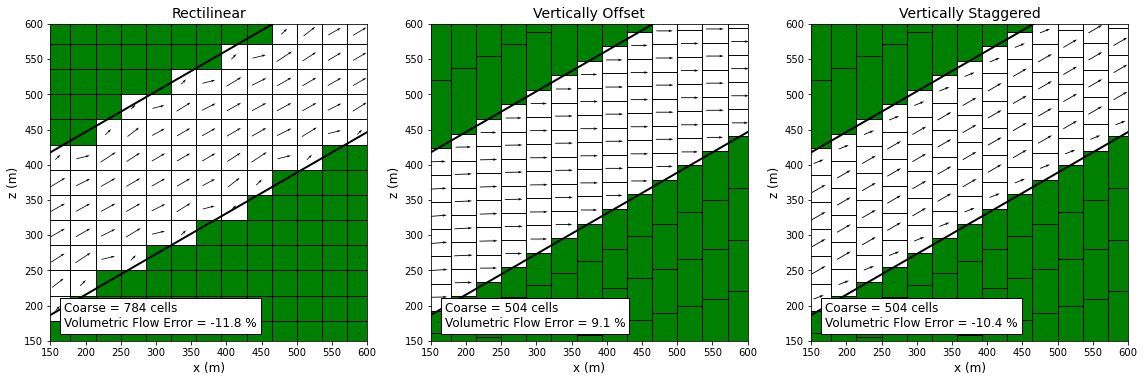

In [19]:
if ncol1 <= 40: # Plots only for coarse resolution

    fig, axes = plt.subplots(1,3, figsize=(16, 8))

    ax1 = plt.subplot(1,3,1,aspect='equal')
    ax1.set_title('Rectilinear', size = 14)  
    xsect = flopy.plot.PlotCrossSection(model=all_gwf[0], line={'Row': 0})
    quadmesh = xsect.plot_array(mask1, cmap='ocean')
    linecollection = xsect.plot_grid(color = 'black', linewidths=0.8)
    vx, vy, vz = all_qxqyqz[0]
    xsect.plot_vector(vx, vy, vz, scale = 20, color='black')

    ax2 = plt.subplot(1,3,2,aspect='equal')
    ax2.set_title('Vertically Offset', size = 14)  
    xsect = flopy.plot.PlotCrossSection(model=all_gwf[1], line={"line": [(0.0, 0.5), (Lx, 0.5)]})
    quadmesh = xsect.plot_array(mask2, cmap='ocean')
    linecollection = xsect.plot_grid(color = 'black', linewidths=0.8)
    vx, vy, vz = all_qxqyqz[1]
    xsect.plot_vector(vx, vy, vz, scale = 20, color='black')
    
    ax3 = plt.subplot(1,3,3,aspect='equal')
    ax3.set_title('Vertically Staggered', size = 14)  
    xsect = flopy.plot.PlotCrossSection(model=all_gwf[2], line={"line": [(0.0, 0.5), (Lx, 0.5)]})
    quadmesh = xsect.plot_array(mask2, cmap='ocean')
    linecollection = xsect.plot_grid(color = 'black', linewidths=0.8)
    vx, vy, vz = all_qxqyqz[2]
    xsect.plot_vector(vx, vy, vz, scale = 20, color='black')
    
    c1, c2 = 100,100+channel_vertical
    ax1.plot((0,Lx),(c1,slope*Lx+c1),color = 'black', lw=2.0)
    ax1.plot((0,Lx),(c2,slope*Lx+c2),color = 'black', lw=2.0)
    ax2.plot((0,Lx),(c1,slope*Lx+c1),color = 'black', lw=2.0)
    ax2.plot((0,Lx),(c2,slope*Lx+c2),color = 'black', lw=2.0)
    ax3.plot((0,Lx),(c1,slope*Lx+c1),color = 'black', lw=2.0)
    ax3.plot((0,Lx),(c2,slope*Lx+c2),color = 'black', lw=2.0)
    ax1.set_xlim([150, 600])
    ax1.set_ylim([150, 600])
    ax2.set_xlim([150, 600])
    ax2.set_ylim([150, 600])
    ax3.set_xlim([150, 600])
    ax3.set_ylim([150, 600])
    ax1.set_xlabel('x (m)', size = 12)
    ax1.set_ylabel('z (m)', size = 12)
    ax2.set_xlabel('x (m)', size = 12)
    ax2.set_ylabel('z (m)', size = 12)
    ax3.set_xlabel('x (m)', size = 12)
    ax3.set_ylabel('z (m)', size = 12)
    ax1.annotate("Coarse = %i cells\nVolumetric Flow Error = %0.1f %%" %(nlay1*nrow1*ncol1,(VOL_FLOW_1 - Q_analytical)/Q_analytical*100),(170,170), 
                 size = 12, bbox=dict(facecolor = 'white'))
    ax2.annotate("Coarse = %i cells\nVolumetric Flow Error = %0.1f %%" %(nlay2*nrow2*ncol2,(VOL_FLOW_2 -Q_analytical)/Q_analytical*100),(170,170), 
                 size = 12, bbox=dict(facecolor = 'white'))
    ax3.annotate("Coarse = %i cells\nVolumetric Flow Error = %0.1f %%" %(nlay2*nrow2*ncol2,(VOL_FLOW_3 -Q_analytical)/Q_analytical*100),(170,170), 
                 size = 12, bbox=dict(facecolor = 'white'))
    plt.tight_layout()    
#    plt.savefig('fig4_transect.tif', dpi=450)
    figure_ext = ".png"
    fpth = os.path.join(
        "..", "figures", "{}{}".format("fig4_transect", figure_ext)
    )
    plt.savefig(fpth)

In [20]:
for i in range(3): print(q_centre[i]) 

for i in range(3): print(theta_centre[i])
    
print(VOL_FLOW_1)
print(VOL_FLOW_2)
print(VOL_FLOW_3)

1.0260419507626544
1.1122310814256653
1.0020306449276792
29.401845754318582
0.09875639323455092
30.04893282336259
176.48880437492238
218.2749194431419
179.27178588907944
